
#**SResNet18 Student Model - TSER for KD**

#**Setup**

---
**Install Libraries**

In [ ]:
!pip install snntorch dagshub mlflow pynvml --quiet

---
**GitHub Code**

In [ ]:
from google.colab import userdata
import os


# Sets environ variables for GitHub
os.environ['GITHUB_TOKEN'] = userdata.get('GITHUB_TOKEN')
os.environ['USER'] = userdata.get('USER')

# Clones the repo and changes dir
!git clone https://${GITHUB_TOKEN}@github.com/${USER}/tser-kd.git
%cd tser-kd/

fatal: destination path 'tser-kd' already exists and is not an empty directory.
/content/tser-kd


---
**Set Seed for Experiment**

In [ ]:
from tser_kd.utils import setup_seed


setup_seed(42)

Random seed: 42


---
**Device Selection**

In [ ]:
import torch


# Selects the device for the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
**MLFlow Setup**

In [ ]:
import mlflow
from mlflow import MlflowClient
import dagshub


# Sets environ variables for MLFlow
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('USER')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')

# Init DagsHub
dagshub.init(repo_owner='matteogianferrari', repo_name='tser-kd', mlflow=True)
TRACKING_URI = "https://dagshub.com/matteogianferrari/tser-kd.mlflow"

# Sets MLFlow tracking URI
mlflow.set_tracking_uri(TRACKING_URI)

# Sets MLFLow experiment name
experiment_name = "TSER-KD Student"

Accessing as matteogianferrari

Initialized MLflow to track repo "matteogianferrari/tser-kd"

Repository matteogianferrari/tser-kd initialized!

#**Hyperparameters**

In [ ]:
# Hyperparamter dictionary
h_dict = {
    "BETA": 0.5, "V_th": 1.0,                               # Leaky Neuron
    "MAX_EPOCHS": 300, "BATCH_SIZE": 32,                    # Training
    "LR_SCHEDULER": "CosineAnnealingLR", "BASE_LR": 1e-3,  # LR
    "OPTIMIZER": "AdamW", "WEIGHT_DECAY": 5e-4,             # Optimizer
    "ES_PATIENCE": 300, "ES_DELTA": 1e-4,                    # Early Stopping
    "HARDWARE": "A100",                                     # GPU
    "ENCODER": "Static", "T": 2,                            # Encoder
    "AUTO_AUG": True, "CUTOUT": True,                       # Dataset
}

#**CIFAR10 Dataset**

---
**Data Loaders Creation**

In [ ]:
from tser_kd.dataset import load_cifar10_data
from torch.utils.data import DataLoader


train_dataset, val_dataset, num_classes = load_cifar10_data(auto_aug=h_dict['AUTO_AUG'], cutout=h_dict['CUTOUT'])

# Creates the train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=h_dict['BATCH_SIZE'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=h_dict['BATCH_SIZE'], shuffle=False, num_workers=2)

---
**Spiking Plot**

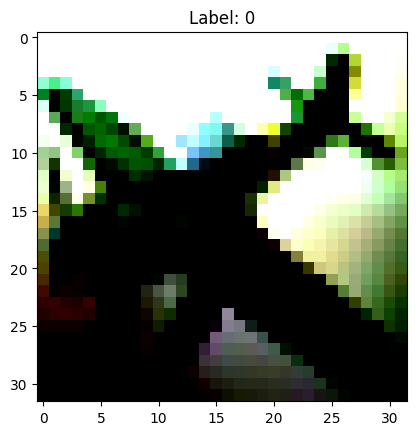

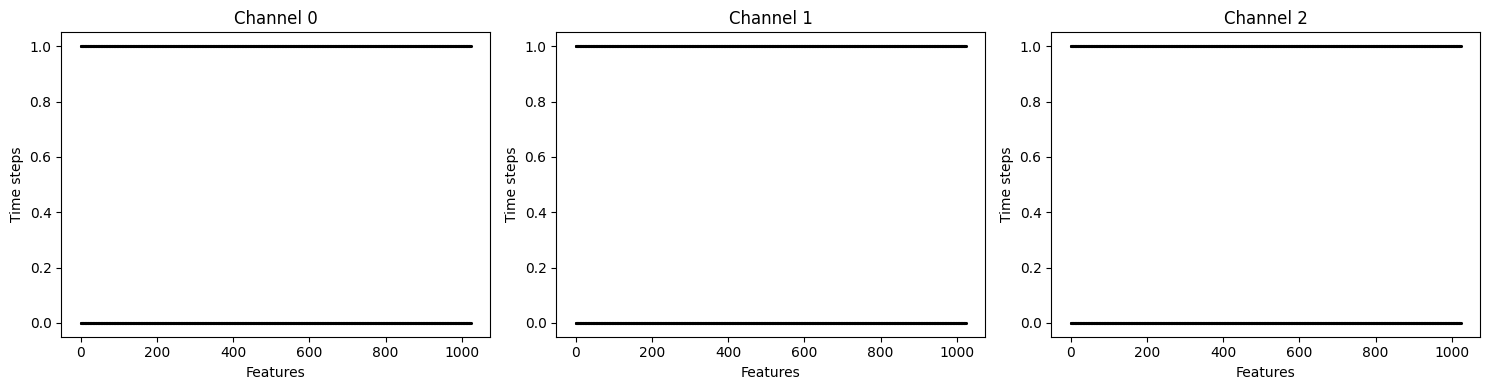

In [ ]:
# snnTorch
from matplotlib import pyplot as plt
from tser_kd.dataset import RateEncoder, StaticEncoder
from tser_kd.utils import plot_spike_train_over_channels, plot_raster_over_channels


# Retrieves a batch of data
X, y = next(iter(val_loader))

idx = 27
X = X[idx]
y = y[idx]


# plot the image
plt.imshow(X.permute(1, 2, 0))
plt.title(f"Label: {y}")
plt.show()


# Converts the images using rate coding, tensor shape: [T, C, H, W]
if h_dict["ENCODER"] == 'Rate':
    spike_train = RateEncoder(num_steps=h_dict['T'], gain=h_dict['GAIN'])(X)
elif h_dict["ENCODER"] == 'Static':
    spike_train = StaticEncoder(num_steps=h_dict['T'])(X)

plot_spike_train_over_channels(spike_train, ['Reds', 'Greens', 'Blues'])
plot_raster_over_channels(spike_train)

del X, y, spike_train

#**S-ResNet18**

---
**Model Creation**

In [ ]:
from tser_kd.model.student import make_student_model
from tser_kd.model.teacher import make_teacher_model


# SNN
s_model = make_student_model(
    arch='sresnet-18',
    in_channels=3,
    num_classes=num_classes,
    beta=h_dict['BETA'],
    device=device
)

---
**Weights Transfer**

In [ ]:
import re
from collections import OrderedDict
import torch.nn as nn

def transfer_resnet18_to_sresnet(src_resnet: nn.Module,
                                 dst_sresnet: nn.Module,
                                 verbose: bool = True) -> None:
    """
    Copy all compatible learnable parameters (Conv, BN, FC) from a trained
    torchvision‑style ResNet‑18 into the corresponding wrapped layers of a
    spiking ResNet‑18 built as in the question.

    Parameters
    ----------
    src_resnet : nn.Module
        The pretrained conventional ResNet‑18.
    dst_sresnet : nn.Module
        The (usually freshly‑initialised) spiking ResNet‑18.
    verbose : bool, optional
        Print a short report of copied / missing tensors.
    """

    # --- helpers -----------------------------------------------------------
    stage_to_layer = {0: "layer1", 1: "layer2", 2: "layer3", 3: "layer4"}
    comp_map = {  # maps the *wrapper* name inside a block to the classic name
        "t_conv_bn1.layer":        "conv1",
        "t_conv_bn1.batch_norm":   "bn1",
        "t_conv_bn2.layer":        "conv2",
        "t_conv_bn2.batch_norm":   "bn2",
        "shortcuts.layer":         "downsample.0",
        "shortcuts.batch_norm":    "downsample.1",
    }

    # grab the state‑dicts
    src_sd = src_resnet.state_dict()
    dst_sd = dst_sresnet.state_dict()
    new_sd = OrderedDict()

    copied, skipped = [], []

    for dst_key, dst_tensor in dst_sd.items():

        # ------------------------------------------------------------------
        # 1) stem (conv + BN)
        # ------------------------------------------------------------------
        if dst_key.startswith("stem.layer."):
            src_key = dst_key.replace("stem.layer", "conv1")

        elif dst_key.startswith("stem.batch_norm."):
            src_key = dst_key.replace("stem.batch_norm", "bn1")

        # ------------------------------------------------------------------
        # 2) residual stages
        #    stages.<stage>.<block>.<wrapper>.<param>
        # ------------------------------------------------------------------
        elif dst_key.startswith("stages."):
            m = re.match(
                r"stages\.(\d+)\.(\d+)\.([^\.]+\.[^\.]+)\.(.+)", dst_key
            )
            if m:
                stage, block, wrapper_name, suffix = m.groups()
                layer_name = stage_to_layer[int(stage)]
                cmp_name = comp_map.get(wrapper_name, None)
                if cmp_name is not None:
                    src_key = f"{layer_name}.{block}.{cmp_name}.{suffix}"
                else:
                    src_key = None
            else:
                src_key = None

        # ------------------------------------------------------------------
        # 3) classifier head
        # ------------------------------------------------------------------
        elif dst_key.startswith("mlp.0.layer."):
            src_key = dst_key.replace("mlp.0.layer", "fc")

        # ------------------------------------------------------------------
        # 4) anything without a counterpart stays untouched
        #    (LIF parameters, SNN‑specific buffers, etc.)
        # ------------------------------------------------------------------
        else:
            src_key = None

        # copy if possible --------------------------------------------------
        if src_key is not None and src_key in src_sd \
           and src_sd[src_key].shape == dst_tensor.shape:
            new_sd[dst_key] = src_sd[src_key].clone()
            copied.append(dst_key)
        else:
            new_sd[dst_key] = dst_tensor  # keep original
            skipped.append(dst_key)

    # load the updated dict
    dst_sresnet.load_state_dict(new_sd, strict=False)

    if verbose:
        print(f"Copied {len(copied)} tensors, skipped {len(skipped)}.")
        if skipped:
            print("Skipped keys (shape mismatch or no counterpart):")
            for k in skipped:
                print("  •", k)


a_state_dict = torch.load("data/teacher_models/resnet18_ft_9661.pth", map_location="cpu")
a_model = make_teacher_model(
    arch='resnet-18',
    in_channels=3,
    num_classes=num_classes,
    device=device,
    state_dict=a_state_dict
)
transfer_resnet18_to_sresnet(a_model, s_model)

Copied 121 tensors, skipped 100.
Skipped keys (shape mismatch or no counterpart):
  • lif_stem.layer.threshold
  • lif_stem.layer.graded_spikes_factor
  • lif_stem.layer.reset_mechanism_val
  • lif_stem.layer.beta
  • stages.0.0.lif1.layer.threshold
  • stages.0.0.lif1.layer.graded_spikes_factor
  • stages.0.0.lif1.layer.reset_mechanism_val
  • stages.0.0.lif1.layer.beta
  • stages.0.0.lif2.layer.threshold
  • stages.0.0.lif2.layer.graded_spikes_factor
  • stages.0.0.lif2.layer.reset_mechanism_val
  • stages.0.0.lif2.layer.beta
  • stages.0.0.lif3.layer.threshold
  • stages.0.0.lif3.layer.graded_spikes_factor
  • stages.0.0.lif3.layer.reset_mechanism_val
  • stages.0.0.lif3.layer.beta
  • stages.0.1.lif1.layer.threshold
  • stages.0.1.lif1.layer.graded_spikes_factor
  • stages.0.1.lif1.layer.reset_mechanism_val
  • stages.0.1.lif1.layer.beta
  • stages.0.1.lif2.layer.threshold
  • stages.0.1.lif2.layer.graded_spikes_factor
  • stages.0.1.lif2.layer.reset_mechanism_val
  • stages.0.1.li

In [ ]:
# Remove the a_model and a_state_dict
# IMPORTANT TO KEEP THE EPOCH TIME LOW
del a_model, a_state_dict
torch.cuda.empty_cache()

#**Training**

---
**Objects Creation**

In [ ]:
import torch.optim as optim
import torch.nn as nn
from tser_kd.training import EarlyStopping
from tser_kd.dataset import RateEncoder, StaticEncoder
from tser_kd.model import TSCELoss
from tser_kd.utils import AccuracyMonitor


# Optimizer
if h_dict["OPTIMIZER"] == 'AdamW':
    optimizer = optim.AdamW(s_model.parameters(), lr=h_dict['BASE_LR'], weight_decay=h_dict['WEIGHT_DECAY'])
elif h_dict["OPTIMIZER"] == 'Adam':
    optimizer = optim.Adam(s_model.parameters(), lr=h_dict['BASE_LR'], weight_decay=h_dict['WEIGHT_DECAY'])
elif h_dict["OPTIMIZER"] == 'SGD':
    optimizer = optim.SGD(s_model.parameters(), lr=h_dict['BASE_LR'], momentum=h_dict["MOMENTUM"], weight_decay=h_dict['WEIGHT_DECAY'])

# LR scheduler
if h_dict["LR_SCHEDULER"] == 'ReduceLROnPlateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=h_dict["LR_PATIENCE"], factor=h_dict["LR_FACTOR"])
elif h_dict["LR_SCHEDULER"] == 'CosineAnnealingLR':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=h_dict["MAX_EPOCHS"])
elif h_dict["LR_SCHEDULER"] == 'StepLR':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=h_dict["LR_STEP"], gamma=h_dict["LR_FACTOR"])
elif h_dict["LR_SCHEDULER"] == 'WarmupCosineLR':
    scheduler = WarmupCosineLR(
        optimizer=optimizer,
        warmup_epochs=h_dict["WARMUP_EPOCHS"],
        total_epochs=h_dict["MAX_EPOCHS"],
        base_lr=h_dict["BASE_LR"],
        max_lr=h_dict["MAX_LR"]
    )

# Losses
train_criterion = TSCELoss()
eval_criterion = nn.CrossEntropyLoss()

# Accuracy monitor
acc_monitor = AccuracyMonitor(path="best_acc.pth")

# Early stopping
es_callback = EarlyStopping(patience=h_dict["ES_PATIENCE"], delta=h_dict["ES_DELTA"], path="best_loss.pth")

# Gradient scaler
scaler = torch.amp.GradScaler(device='cuda')

# Encoder
if h_dict["ENCODER"] == "Rate":
    encoder = RateEncoder(num_steps=h_dict["T"], gain=h_dict["GAIN"])
elif h_dict["ENCODER"] == "Static":
    encoder = StaticEncoder(num_steps=h_dict["T"])

---
**Training Loop**

In [ ]:
import pynvml
from tser_kd.eval import run_eval
from tser_kd.training import run_train


# PER FARE UN RESUME SERVE IL MODELLO CHECKPOINT, LA START_EPOCH, LA RUN_ID, E LAST_EPOCH IN SCHEDULER

# Sets the MLFlow experiment
mlflow.set_experiment(experiment_name)

epoch_i = 0
curr_lr = optimizer.param_groups[0]["lr"]

# Train the model and log with MLFlow
with mlflow.start_run(run_id=None, log_system_metrics=True):
    for epoch_i in range(h_dict["MAX_EPOCHS"]):
        train_loss, train_acc, epoch_time, train_batch_time = run_train(
            epoch_i, train_loader, s_model, train_criterion, optimizer, device, scaler, encoder
        )

        val_loss, val_acc1, val_acc5, val_batch_time = run_eval(val_loader, s_model, eval_criterion, device, encoder)

        # Logging
        print(
            f"Time: {epoch_time:.1f}s | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc1: {val_acc1:.2f}% | Val Acc5: {val_acc5:.2f}% | LR: {curr_lr:.6f}"
        )

        mlflow.log_metrics({
            "learning_rate": curr_lr, "train_tsce_loss": train_loss, "train_acc": train_acc, "val_ce_loss": val_loss,
            "val_acc1": val_acc1, "val_acc5": val_acc5, "epoch_time": epoch_time,
            "train_batch_time": train_batch_time, "val_batch_time": val_batch_time
        }, step=epoch_i)

        # Updates the LR
        if h_dict["LR_SCHEDULER"] == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        curr_lr = optimizer.param_groups[0]["lr"]

        # Accuracy monitor
        acc_monitor(val_acc1, epoch_i, s_model)

        # ES check
        if es_callback(val_loss, epoch_i, s_model):
            break


    # Log hyperparameters
    mlflow.log_params(h_dict)

    # Log test performance
    s_model.load_state_dict(torch.load("best_acc.pth"))
    test_ce_loss, test_acc1, test_acc5, _ = run_eval(val_loader, s_model, eval_criterion, device, encoder)
    mlflow.log_metrics({"test_ce_loss": test_ce_loss, "test_acc1": test_acc1, "test_acc5": test_acc5})

2025/07/30 14:27:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Epoch 1: 100%|██████████| Batch 1563/1563 , acc=11.20%, loss=2.2887


Time: 175.8s | Train Loss: 2.2887 | Train Acc: 11.20% | Val Loss: 2.2364 | Val Acc1: 15.57% | Val Acc5: 67.73% | LR: 0.001000


Epoch 2: 100%|██████████| Batch 1563/1563 , acc=12.30%, loss=2.2692


Time: 174.6s | Train Loss: 2.2692 | Train Acc: 12.30% | Val Loss: 2.2190 | Val Acc1: 18.72% | Val Acc5: 69.77% | LR: 0.001000


Epoch 3: 100%|██████████| Batch 1563/1563 , acc=13.17%, loss=2.2504


Time: 174.8s | Train Loss: 2.2504 | Train Acc: 13.17% | Val Loss: 2.2066 | Val Acc1: 17.94% | Val Acc5: 64.54% | LR: 0.001000


Epoch 4: 100%|██████████| Batch 1563/1563 , acc=14.91%, loss=2.2103


Time: 174.8s | Train Loss: 2.2103 | Train Acc: 14.91% | Val Loss: 2.1574 | Val Acc1: 25.47% | Val Acc5: 78.17% | LR: 0.001000


Epoch 5: 100%|██████████| Batch 1563/1563 , acc=16.66%, loss=2.1920


Time: 174.1s | Train Loss: 2.1920 | Train Acc: 16.66% | Val Loss: 2.1271 | Val Acc1: 26.23% | Val Acc5: 79.41% | LR: 0.001000


Epoch 6: 100%|██████████| Batch 1563/1563 , acc=20.91%, loss=2.1064


Time: 174.0s | Train Loss: 2.1064 | Train Acc: 20.91% | Val Loss: 2.0159 | Val Acc1: 29.29% | Val Acc5: 82.88% | LR: 0.000999


Epoch 7: 100%|██████████| Batch 1563/1563 , acc=25.58%, loss=1.9982


Time: 173.8s | Train Loss: 1.9982 | Train Acc: 25.58% | Val Loss: 1.8964 | Val Acc1: 36.58% | Val Acc5: 87.33% | LR: 0.000999


Epoch 8: 100%|██████████| Batch 1563/1563 , acc=29.63%, loss=1.9033


Time: 173.6s | Train Loss: 1.9033 | Train Acc: 29.63% | Val Loss: 1.7491 | Val Acc1: 42.39% | Val Acc5: 91.46% | LR: 0.000999


Epoch 9: 100%|██████████| Batch 1563/1563 , acc=35.56%, loss=1.7710


Time: 172.9s | Train Loss: 1.7710 | Train Acc: 35.56% | Val Loss: 1.5855 | Val Acc1: 47.88% | Val Acc5: 92.72% | LR: 0.000998


Epoch 10: 100%|██████████| Batch 1563/1563 , acc=40.69%, loss=1.6399


Time: 174.0s | Train Loss: 1.6399 | Train Acc: 40.69% | Val Loss: 1.5529 | Val Acc1: 46.63% | Val Acc5: 93.23% | LR: 0.000998


Epoch 11: 100%|██████████| Batch 1563/1563 , acc=44.86%, loss=1.5407


Time: 176.0s | Train Loss: 1.5407 | Train Acc: 44.86% | Val Loss: 1.4724 | Val Acc1: 49.03% | Val Acc5: 91.65% | LR: 0.000997


Epoch 12: 100%|██████████| Batch 1563/1563 , acc=47.83%, loss=1.4578


Time: 174.5s | Train Loss: 1.4578 | Train Acc: 47.83% | Val Loss: 1.4063 | Val Acc1: 54.68% | Val Acc5: 93.26% | LR: 0.000997


Epoch 13: 100%|██████████| Batch 1563/1563 , acc=50.19%, loss=1.4008


Time: 174.9s | Train Loss: 1.4008 | Train Acc: 50.19% | Val Loss: 1.4909 | Val Acc1: 49.79% | Val Acc5: 93.61% | LR: 0.000996


Epoch 14: 100%|██████████| Batch 1563/1563 , acc=51.95%, loss=1.3569


Time: 173.8s | Train Loss: 1.3569 | Train Acc: 51.95% | Val Loss: 1.3441 | Val Acc1: 58.83% | Val Acc5: 95.03% | LR: 0.000995


Epoch 15: 100%|██████████| Batch 1563/1563 , acc=53.46%, loss=1.3119


Time: 174.7s | Train Loss: 1.3119 | Train Acc: 53.46% | Val Loss: 1.3922 | Val Acc1: 57.55% | Val Acc5: 94.15% | LR: 0.000995


Epoch 16: 100%|██████████| Batch 1563/1563 , acc=55.03%, loss=1.2694


Time: 174.7s | Train Loss: 1.2694 | Train Acc: 55.03% | Val Loss: 1.5164 | Val Acc1: 50.35% | Val Acc5: 90.22% | LR: 0.000994


Epoch 17: 100%|██████████| Batch 1563/1563 , acc=56.29%, loss=1.2368


Time: 174.6s | Train Loss: 1.2368 | Train Acc: 56.29% | Val Loss: 1.7690 | Val Acc1: 41.19% | Val Acc5: 82.36% | LR: 0.000993


Epoch 18: 100%|██████████| Batch 1563/1563 , acc=57.72%, loss=1.1965


Time: 174.6s | Train Loss: 1.1965 | Train Acc: 57.72% | Val Loss: 1.6824 | Val Acc1: 45.71% | Val Acc5: 83.97% | LR: 0.000992


Epoch 19: 100%|██████████| Batch 1563/1563 , acc=59.27%, loss=1.1633


Time: 175.1s | Train Loss: 1.1633 | Train Acc: 59.27% | Val Loss: 1.7522 | Val Acc1: 41.55% | Val Acc5: 84.70% | LR: 0.000991


Epoch 20:  14%|█▍        | Batch 225/1563 , acc=59.96%, loss=1.1397
2025/07/30 15:29:36 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


🏃 View run fearless-dolphin-830 at: https://dagshub.com/matteogianferrari/tser-kd.mlflow/#/experiments/1/runs/8bce1bc429d548089714c754d2ec5387
🧪 View experiment at: https://dagshub.com/matteogianferrari/tser-kd.mlflow/#/experiments/1


2025/07/30 15:29:36 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


KeyboardInterrupt: 

In [ ]:
https://arxiv.org/pdf/1609.04836

In [ ]:
import os, hashlib

def file_info(path):
    size = os.path.getsize(path)
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            h.update(chunk)
    return size, h.hexdigest()

for fn in ["best_ckpt.pth"]:
    sz, md5 = file_info(fn)
    print(f"{fn}: {sz/1e6:.2f} MB,  md5={md5}")


In [ ]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from tser_kd.model.teacher import make_teacher_model


@torch.no_grad()
def load_resnet18_backbone_into_resnet19(model):
    """
    Copies ImageNet-pretrained ResNet-18 weights into your CIFAR ResNet19 backbone.
    Leaves stem and FC layers as-is. Returns a small report dict.
    """
    res18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # already loaded

    def copy_conv(dst, src):
        assert dst.weight.shape == src.weight.shape, f"conv shape mismatch: {dst.weight.shape} vs {src.weight.shape}"
        dst.weight.copy_(src.weight)
        if getattr(dst, "bias", None) is not None and getattr(src, "bias", None) is not None:
            dst.bias.copy_(src.bias)

    def copy_bn(dst, src):
        assert dst.weight.shape == src.weight.shape, f"bn shape mismatch: {dst.weight.shape} vs {src.weight.shape}"
        dst.weight.copy_(src.weight)
        dst.bias.copy_(src.bias)
        dst.running_mean.copy_(src.running_mean)
        dst.running_var.copy_(src.running_var)
        if hasattr(dst, "num_batches_tracked") and hasattr(src, "num_batches_tracked"):
            dst.num_batches_tracked.copy_(src.num_batches_tracked)

    def copy_block(dst_block, src_block, copy_shortcut=False):
        copy_conv(dst_block.conv1, src_block.conv1); copy_bn(dst_block.bn1, src_block.bn1)
        copy_conv(dst_block.conv2, src_block.conv2); copy_bn(dst_block.bn2, src_block.bn2)
        if copy_shortcut and (dst_block.shortcuts is not None) and (src_block.downsample is not None):
            # conv + bn in the 1x1 projection
            copy_conv(dst_block.shortcuts[0], src_block.downsample[0])
            copy_bn(dst_block.shortcuts[1],  src_block.downsample[1])

    # ---- Mappings ----
    # block1 (128 ch): use layer2[1] (128->128 stride 1) for all three
    for i in range(3):
        copy_block(model.block1[i], res18.layer2[1], copy_shortcut=False)

    # block2 (256 ch): first with downsample, then two stride-1 blocks
    copy_block(model.block2[0], res18.layer3[0], copy_shortcut=True)   # 128->256, stride 2
    copy_block(model.block2[1], res18.layer3[1], copy_shortcut=False)  # 256->256
    copy_block(model.block2[2], res18.layer3[1], copy_shortcut=False)  # duplicate

    # block3 (512 ch): first with downsample, then stride-1
    copy_block(model.block3[0], res18.layer4[0], copy_shortcut=True)   # 256->512, stride 2
    copy_block(model.block3[1], res18.layer4[1], copy_shortcut=False)  # 512->512

    report = {
        "copied_from_resnet18": {
            "block1": ["layer2[1] → block1[0,1,2]"],
            "block2": ["layer3[0] → block2[0] (with shortcut)",
                       "layer3[1] → block2[1,2]"],
            "block3": ["layer4[0] → block3[0] (with shortcut)",
                       "layer4[1] → block3[1]"],
        },
        "left_random_init": ["stem conv/bn", "fc1", "fc2"],
    }
    return report

resnet19 = make_teacher_model(arch='resnet-19', in_channels=3, num_classes=10, device=device)
load_resnet18_backbone_into_resnet19(resnet19)